In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

tf.__version__


'2.19.0'

In [2]:
SELECTED_CLASSES = [
    "pizza","sushi","ice_cream","french_fries","steak",
    "ramen","fried_rice","cup_cakes","apple_pie","donuts",
    "chicken_wings","hot_dog","cheesecake","grilled_salmon","hamburger"
]

NUM_CLASSES = len(SELECTED_CLASSES)
NUM_CLASSES


15

In [3]:
(ds_train_raw, ds_test_raw), ds_info = tfds.load(
    "food101",
    split=["train", "validation"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

label_names = ds_info.features["label"].names
label_map = {name: i for i, name in enumerate(label_names)}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4C3OP6_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.4C3OP6_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
selected_label_ids = [label_map[c] for c in SELECTED_CLASSES]

selected_ids_tf = tf.constant(selected_label_ids, dtype=tf.int64)

table = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(
        keys=selected_ids_tf,
        values=tf.range(NUM_CLASSES, dtype=tf.int64)
    ),
    default_value=-1
)


In [5]:
def filter_selected(image, label):
    return tf.reduce_any(tf.equal(label, selected_ids_tf))

def remap_label(image, label):
    return image, table.lookup(label)

ds_train = ds_train_raw.filter(filter_selected).map(remap_label)
ds_test  = ds_test_raw.filter(filter_selected).map(remap_label)


In [6]:
IMG_SIZE = 128

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test  = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,394,255 (28.21 MB)

 Trainable params: 7,394,255 (28.21 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    ds_train,
    epochs=5,
    validation_data=ds_test
)


Epoch 1/5
    352/Unknown 360s 1s/step - accuracy: 0.1233 - loss: 2.6200

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


352/352 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.1234 - loss: 2.6198 - val_accuracy: 0.2349 - val_loss: 2.3492
Epoch 2/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 446s 1s/step - accuracy: 0.2237 - loss: 2.3847 - val_accuracy: 0.2667 - val_loss: 2.2652
Epoch 3/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.3033 - loss: 2.1681 - val_accuracy: 0.2821 - val_loss: 2.2190
Epoch 4/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 439s 1s/step - accuracy: 0.3997 - loss: 1.8627 - val_accuracy: 0.2824 - val_loss: 2.2563
Epoch 5/5
352/352 ━━━━━━━━━━━━━━━━━━━━ 420s 1s/step - accuracy: 0.5172 - loss: 1.4814 - val_accuracy: 0.2867 - val_loss: 2.3271


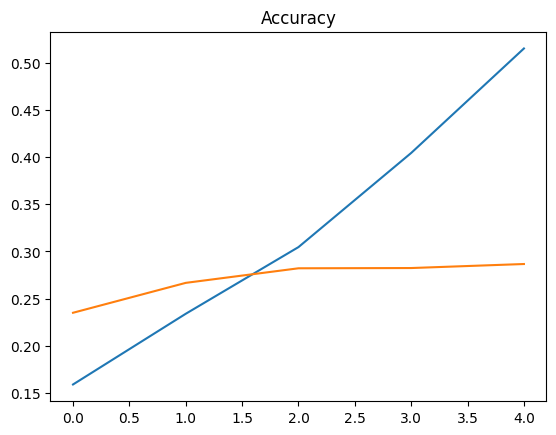

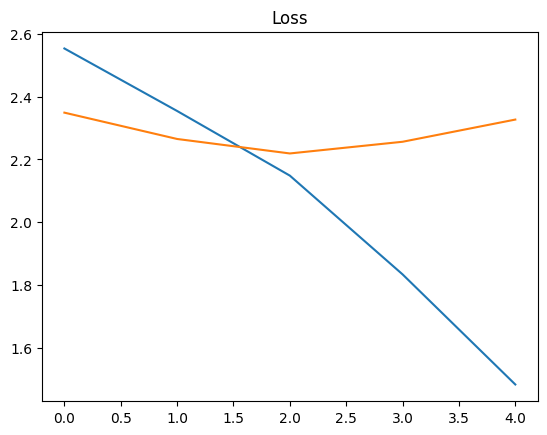

In [11]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.show()

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.show()


In [12]:
test_loss, test_acc = model.evaluate(ds_test)
test_acc


118/118 ━━━━━━━━━━━━━━━━━━━━ 76s 643ms/step - accuracy: 0.2970 - loss: 2.2980


0.2866666615009308

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 718ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

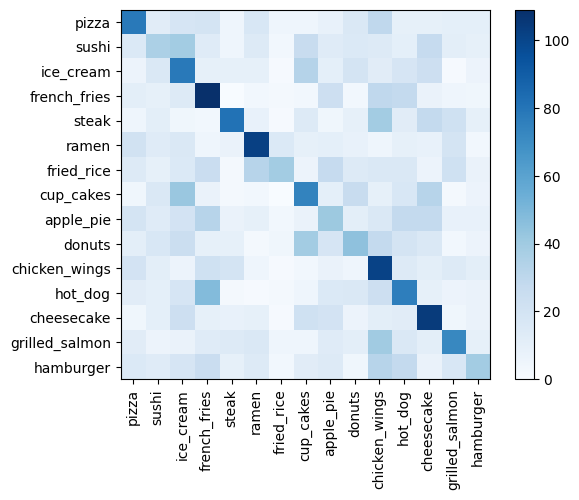

In [13]:
y_true, y_pred = [], []

for images, labels in ds_test:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=SELECTED_CLASSES))

cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.xticks(range(NUM_CLASSES), SELECTED_CLASSES, rotation=90)
plt.yticks(range(NUM_CLASSES), SELECTED_CLASSES)
plt.show()


In [14]:
from tensorflow.keras.preprocessing import image

def predict_food(path):
    img = image.load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img) / 255.0
    x = np.expand_dims(x, axis=0)

    pred = model.predict(x)[0]
    idx = np.argmax(pred)

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{SELECTED_CLASSES[idx]} ({pred[idx]:.2f})")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


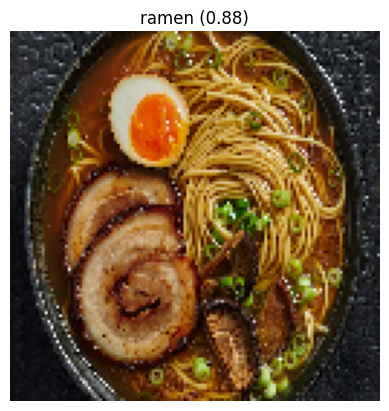

In [16]:
predict_food("/content/ramen.jpg")
